In [1]:
#Uploading files
from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()

Saving PlayList.csv to PlayList.csv


Saving InjuryRecord.csv to InjuryRecord.csv


In [2]:
#Loading uploaded files into a dataframe
import pandas as pd

PlayList = next(iter(uploaded1))
InjuryRecord = next(iter(uploaded2))

df_PlayList = pd.read_csv(PlayList)
df_InjuryRecord = pd.read_csv(InjuryRecord)

In [3]:
#Data Cleaning -- Replacing missing values in Position and PositionGRoup feature columns with abbreviation of Roster Position
# Create a mapping dictionary for Roster Position abbreviations
position_mapping = {
  'Quarterback': {'Position': 'QB', 'PositionGroup': 'QB'},
  'Wide Receiver': {'Position': 'WR', 'PositionGroup': 'WR'},
  'Linebacker': {'Position': 'ILB', 'PositionGroup': 'LB'},
  'Running Back': {'Position': 'RB', 'PositionGroup': 'RB'},
  'Defensive Lineman': {'Position': 'DE', 'PositionGroup': 'DL'},
  'Tight End': {'Position': 'TE', 'PositionGroup': 'TE'},
  'Safety': {'Position': 'FS', 'PositionGroup': 'DB'},
  'Cornerback': {'Position': 'CB', 'PositionGroup': 'DB'},
  'Offensive Lineman': {'Position': 'G', 'PositionGroup': 'OL'},
  'Kicker': {'Position': 'K', 'PositionGroup': 'SPEC'}
}
# Assigning position mapped values to their respective rows in Position and Position Group columns
df_PlayList['Position'] = df_PlayList.apply(lambda x: x['RosterPosition'][:2] if x['Position'] == 'Missing Data' else x['Position'], axis=1)
df_PlayList['PositionGroup'] = df_PlayList.apply(lambda x: x['RosterPosition'][:2] if x['PositionGroup'] == 'Missing Data' else x['PositionGroup'], axis=1)

#Removing null values and bad data
df_PlayList = df_PlayList.dropna()

df_PlayList = df_PlayList.drop(df_PlayList[df_PlayList.eq(-999).any(axis=1)].index)


#Map Weather to respective bins:
'''
Clear = 1
Partly = 2
Cloudy = 3
Rain = 4
Indoor = 5
Hot = 6
Cold = 7
Snow = 8
'''
weather_mapping = [['Sunny','Clear', 'Clear skies', 'Mostly Sunny', 'Sunny and warm', 'Clear and Cool', 'Clear and cold', 'Sunny and cold', 'Sunny and clear','Sunny, highs to upper 80s', 'Clear and warm', 'Sunny, Windy', 'Sunny Skies', 'Fair', 'Clear Skies', 'Clear and sunny', 'Clear and Sunny'],
                   ['Party Cloudy', 'Partly Cloudy', 'Partly Sunny', 'Partly cloudy', 'Mostly Sunny Skies', 'Partly sunny', 'Partly clear', 'Partly Clouidy', 'Mostly sunny', 'Clear to Partly Cloudy', 'Sun & clouds', 'Hazy'],
                   ['Cloudy', 'Cloudy, fog started developing in 2nd quarter', 'Mostly Cloudy', 'Cloudy and cold', 'Cloudy and Cool', 'Mostly Coudy', 'Cloudy, chance of rain', 'Mostly cloudy', 'Coudy', 'cloudy', 'Overcast'],
                   ['Rain', 'Showers', 'Rain Chance 40%', 'Light Rain', '10% Chance of Rain', 'Cloudy, 50% change of rain', '30% Chance of Rain', 'Rainy', 'Rain shower', 'Scattered Showers', 'Cloudy, Rain', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.', 'Rain likely, temps in low 40s.'],
                   ['Indoors', 'Controlled Climate', 'Indoor'],
                   ['Heat Index 95'],
                   ['Cold'],
                   ['Heavy lake effect snow', 'Cloudy, light snow accumulating 1-3"', 'Snow']]

mapping_dict = {value: i+1 for i, sublist in enumerate(weather_mapping) for value in sublist}

df_PlayList['Weather'] = df_PlayList['Weather'].map(mapping_dict).astype(int)

In [4]:
# Creating feature column to sum the amount of days more than a week a player has been injured

for x in range(len(df_InjuryRecord)):
  df_InjuryRecord.loc[df_InjuryRecord['DM_M7'] == 1, 'Injured >=7 days'] = 1
  df_InjuryRecord.loc[df_InjuryRecord['DM_M7'] == 0, 'Injured >=7 days'] = 0

df_InjuryRecord['Injured >=7 days'] = df_InjuryRecord['Injured >=7 days'].astype(int)


#One Hot Encoding Surface type
df_InjuryRecord['Surface_Encoded'] = df_InjuryRecord['Surface'].map({'Natural': 0, 'Synthetic': 1})

In [5]:
#Combine both datasets based on primary key: Player Key

df = pd.merge(df_PlayList, df_InjuryRecord, on='PlayerKey', how='inner')

#More Data Cleaning
#Dropping any rows that dont contain any injury reports
df = df.dropna()

In [6]:
df.head()

,PlayerKey,GameID_x,PlayKey_x,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,...,GameID_y,PlayKey_y,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,Injured >=7 days,Surface_Encoded
0,31070,31070-1,31070-1-1,Running Back,1,1,Outdoors,Natural,67,1,...,31070-3,31070-3-7,Knee,Natural,1,1,1,1,1,0
1,31070,31070-1,31070-1-2,Running Back,1,1,Outdoors,Natural,67,1,...,31070-3,31070-3-7,Knee,Natural,1,1,1,1,1,0
2,31070,31070-1,31070-1-3,Running Back,1,1,Outdoors,Natural,67,1,...,31070-3,31070-3-7,Knee,Natural,1,1,1,1,1,0
3,31070,31070-1,31070-1-4,Running Back,1,1,Outdoors,Natural,67,1,...,31070-3,31070-3-7,Knee,Natural,1,1,1,1,1,0
4,31070,31070-1,31070-1-5,Running Back,1,1,Outdoors,Natural,67,1,...,31070-3,31070-3-7,Knee,Natural,1,1,1,1,1,0


In [8]:
#Normalization of Temperature
from sklearn.preprocessing import MinMaxScaler
import numpy as np

unique_values = df['Temperature'].unique()

#Normalize Unique Values
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(unique_values.reshape(-1, 1))

#Map Normalized Values Back to Rows
normalized_mapping = dict(zip(unique_values, normalized_values.flatten()))
df['Temperature_Normalized'] = df['Temperature'].map(normalized_mapping)

In [14]:
#Regression Techniques
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error


#Split into features columns and focused data
X = df[['Temperature_Normalized','Surface_Encoded','PlayerGame']]
y = df['Injured >=7 days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

#Logistic Regression
logR = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = logR.predict(X_test)
print('Logistic Regression Accuracy Score:',round(accuracy_score(y_test, y_pred),2))
print('Logistic Regression MSE:',round(mean_squared_error(y_test, y_pred),2))

#DecisionTreeClassifier
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

print('Decision Tree Classifier Accuracy Score:',round(accuracy_score(y_test, tree_pred),2))

#RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

print('Random Forest Classifier Accuracy Score:',round(accuracy_score(y_test, y_pred),2))

Logistic Regression Accuracy Score: 0.69
Logistic Regression MSE: 0.31
Decision Tree Classifier Accuracy Score: 0.91
Random Forest Classifier Accuracy Score: 0.91


In [30]:
# Confusion matrices for regresson techniques
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,accuracy_score


#Logistic Regression Accuracy, Precision, and Recall
y_true = df['Injured >=7 days']
logR_pred = logR.predict(X_test)

precision = precision_score(y_test, logR_pred)
recall = recall_score(y_test, logR_pred)
accuracy = accuracy_score(y_test, logR_pred)

print("Logistic Regression Scores:")
print("Accuracy:", round((accuracy),2))
print("Precision:", round((precision),2))
print("Recall:", round((recall),2))
print()

#Logistic Regression Feature Importances
print("Logistic Regression Feature Importances:")
feature_importances = logR.coef_[0]
absolute_importances = np.abs(feature_importances)
feature_names = ["Temperature_Normalized", "Surface_Encoded", "PlayerGame"]
feature_importance_dict = dict(zip(feature_names, absolute_importances))

# Print or further analyze the feature importances
for feature, importance in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")



#Decision Tree Classifier Accuracy, Precision, and Recall
y_true = df['Injured >=7 days']
tree_pred = tree_model.predict(X_test)

precision = precision_score(y_test, tree_pred)
recall = recall_score(y_test, tree_pred)
accuracy = accuracy_score(y_test, tree_pred)

print()
print("Decision Tree Classifier Scores:")
print("Accuracy:", round((accuracy),2))
print("Precision:", round((precision),2))
print("Recall:", round((recall),2))

print()
feature_importances = tree_model.feature_importances_
print("Decision Tree Classifier Feature Importances:")
print("Temperature_Normalized:", round((feature_importances[0]),2))
print("Surface_Encoded:", round((feature_importances[1]),2))
print("PlayerGame:", round((feature_importances[2]),2))



#Random Forest Classifier Accuracy, Precision, and Recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print()
print("Random Forest Classifier Scores:")
print("Accuracy:", round((accuracy),2))
print("Precision:", round((precision),2))
print("Recall:", round((recall),2))

# Compute confusion matrix
y_true = df['Injured >=7 days']
y_pred = rf_classifier.predict(X)
cm = confusion_matrix(y_true, y_pred)

# Extract TP, TN, FP, FN from the confusion matrix
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

#Confusion Matrix ofr RandomForestClassifier
print()
print("Random Forest Classifier Confusion Matrix:")
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

#Feature Importances
print()
feature_importances = rf_classifier.feature_importances_
print("Random Forest Classifier Feature Importances:")
print("Temperature_Normalized:", round((feature_importances[0]),2))
print("Surface_Encoded:", round((feature_importances[1]),2))
print("PlayerGame:", round((feature_importances[2]),2))

Logistic Regression Scores:
Accuracy: 0.69
Precision: 0.69
Recall: 0.97

Logistic Regression Feature Importances:
Temperature_Normalized: 0.9969334322435696
PlayerGame: 0.053257126125560626
Surface_Encoded: 0.05223433691424478

Decision Tree Classifier Scores:
Accuracy: 0.91
Precision: 0.92
Recall: 0.94

Decision Tree Classifier Feature Importances:
Temperature_Normalized: 0.47
Surface_Encoded: 0.12
PlayerGame: 0.41

Random Forest Classifier Scores:
Accuracy: 0.91
Precision: 0.92
Recall: 0.95

Random Forest Classifier Confusion Matrix:
True Positives (TP): 35008
True Negatives (TN): 15491
False Positives (FP): 3052
False Negatives (FN): 2036

Random Forest Classifier Feature Importances:
Temperature_Normalized: 0.59
Surface_Encoded: 0.01
PlayerGame: 0.4


# Plots


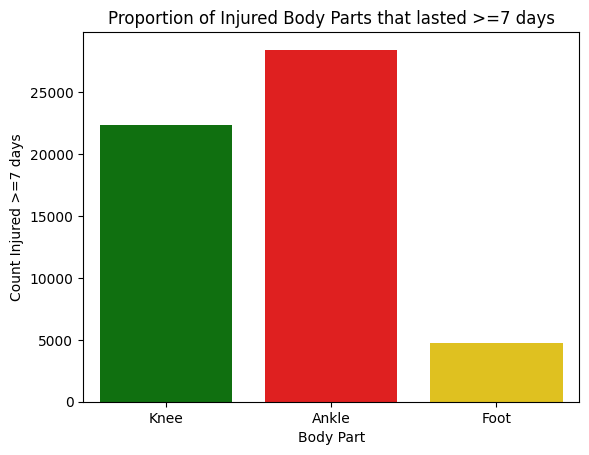

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named df

# Create a countplot with the specified order
custom_palette = ['green', 'red', 'gold']
sns.countplot(x='BodyPart', data=df, palette=custom_palette, order=df[df['Injured >=7 days'] == 1]['BodyPart'].value_counts().index)

# Set plot labels and title
plt.title('Proportion of Injured Body Parts that lasted >=7 days')
plt.xlabel('Body Part')
plt.ylabel('Count Injured >=7 days')

# Show the plot
plt.show()

<ipython-input-85-ae568282fe78>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.countplot(x='BodyPart', hue='Surface', data=df_InjuryRecord[df['Injured >=7 days'] == 1], palette=custom_palette)


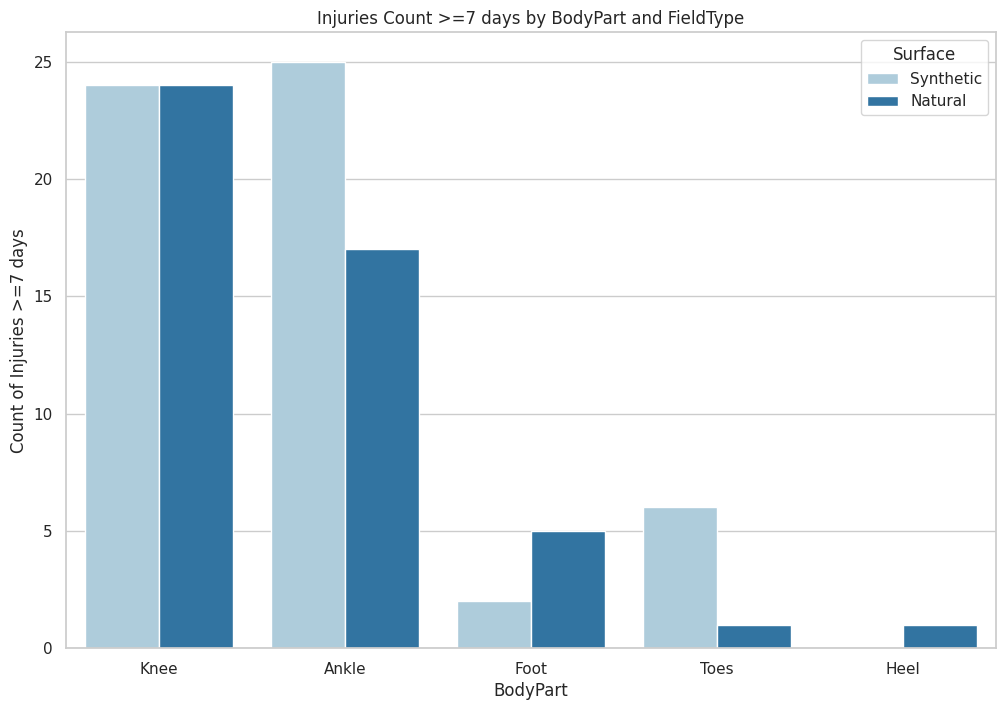

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
custom_palette = sns.color_palette('Paired')  # You can choose any other Seaborn or custom color palette

# Assuming your DataFrame is named df
plt.figure(figsize=(12, 8))

# Set the style without white grid
sns.despine(left=True)

# Create a seaborn count plot with the specified palette
sns.countplot(x='BodyPart', hue='Surface', data=df_InjuryRecord[df['Injured >=7 days'] == 1], palette=custom_palette)

# Remove the white grid

# Set the title and labels
plt.title('Injuries Count >=7 days by BodyPart and FieldType')
plt.xlabel('BodyPart')
plt.ylabel('Count of Injuries >=7 days')

# Show the plot
plt.show()

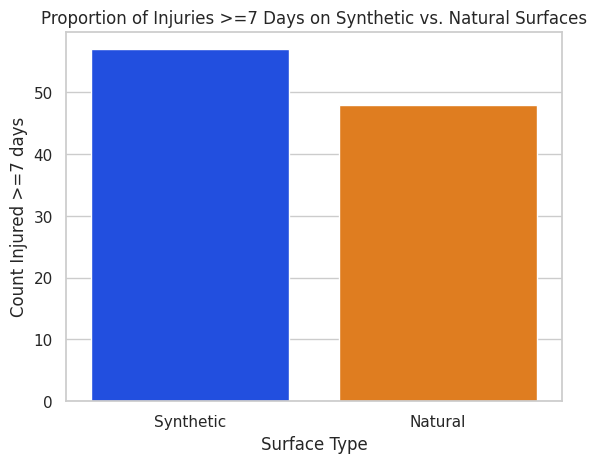

In [ ]:
#Making a plot to display differences of week+ long injuries on synthetic of natural surfaces
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
custom_palette = sns.color_palette('bright')
sns.countplot(x=df_InjuryRecord['Surface'], data=df_InjuryRecord, palette=custom_palette)
plt.title('Proportion of Injuries >=7 Days on Synthetic vs. Natural Surfaces')
plt.xlabel('Surface Type')
plt.ylabel('Count Injured >=7 days')
plt.show()

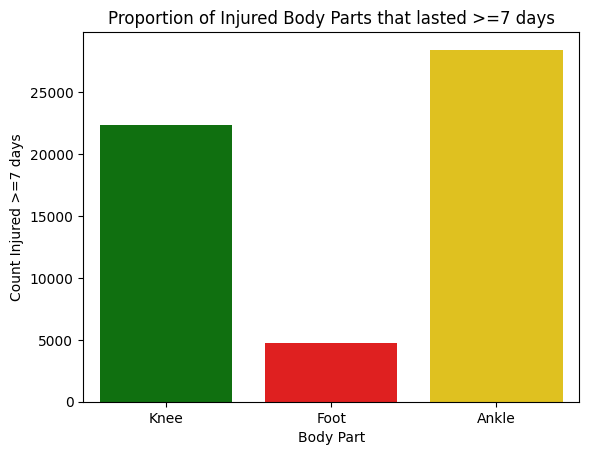

In [ ]:
#Visualizing the more common
import seaborn as sns
import matplotlib.pyplot as plt
custom_palette = ['green', 'red', 'gold']
sns.countplot(x=df['BodyPart'], data=df, palette=custom_palette)
plt.title('Proportion of Injured Body Parts that lasted >=7 days')
plt.xlabel('Body Part')
plt.ylabel('Count Injured >=7 days')
plt.show()

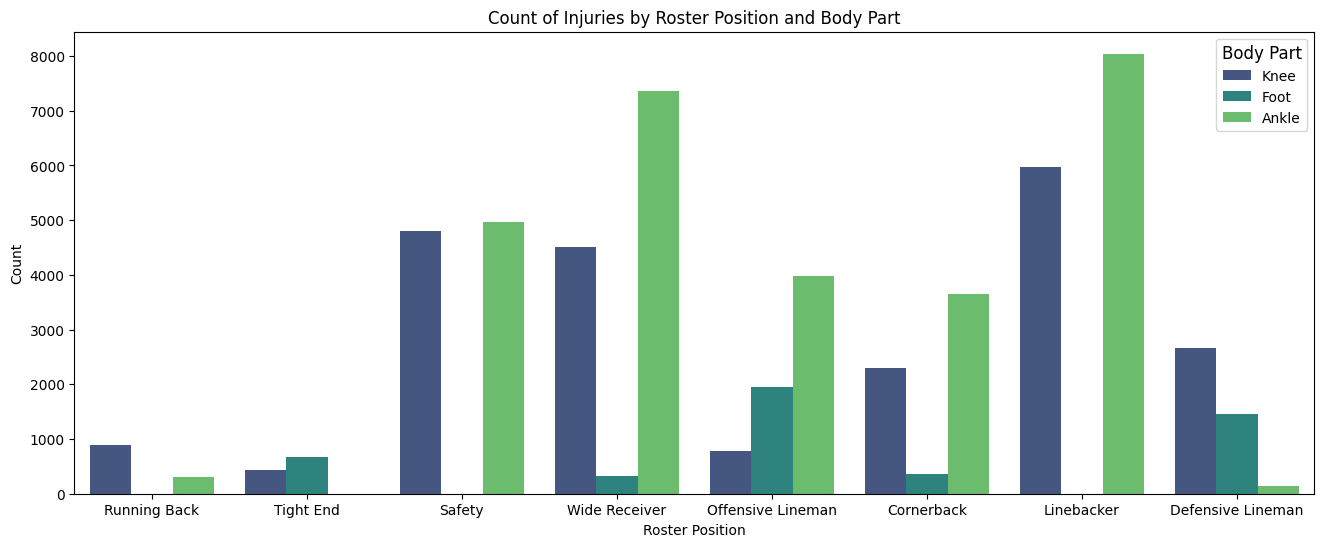

In [ ]:
#Shows the injury count by roster position
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 6))

sns.countplot(x=df['RosterPosition'], hue=df['BodyPart'], data=df, palette='viridis')

plt.title('Count of Injuries by Roster Position and Body Part')
plt.xlabel('Roster Position')
plt.ylabel('Count')
plt.legend(title='Body Part', title_fontsize='12')

plt.show()


In [ ]:
#Percentage of injuries that occured on sufaces
synthetic = df_InjuryRecord['Surface'].value_counts()[0]
natural = df_InjuryRecord['Surface'].value_counts()[1]

#Synthetic surface has 18.75% more injuries than natural
round(((synthetic-natural)/natural)*100,2)

18.75

In [ ]:
# days missed vs surface
days_missed_surface = df_InjuryRecord.groupby('Surface').agg(day_1=('DM_M1',np.count_nonzero),days_7=('DM_M7',np.count_nonzero),days_28=('DM_M28',np.count_nonzero),days_42=('DM_M42',np.count_nonzero))
days_missed_surface

,day_1,days_7,days_28,days_42
Surface,,,,
Natural,48,35,15,13
Synthetic,57,41,22,16


Text(0.5, 0.98, 'Number of Injury Occurances by Temperature')

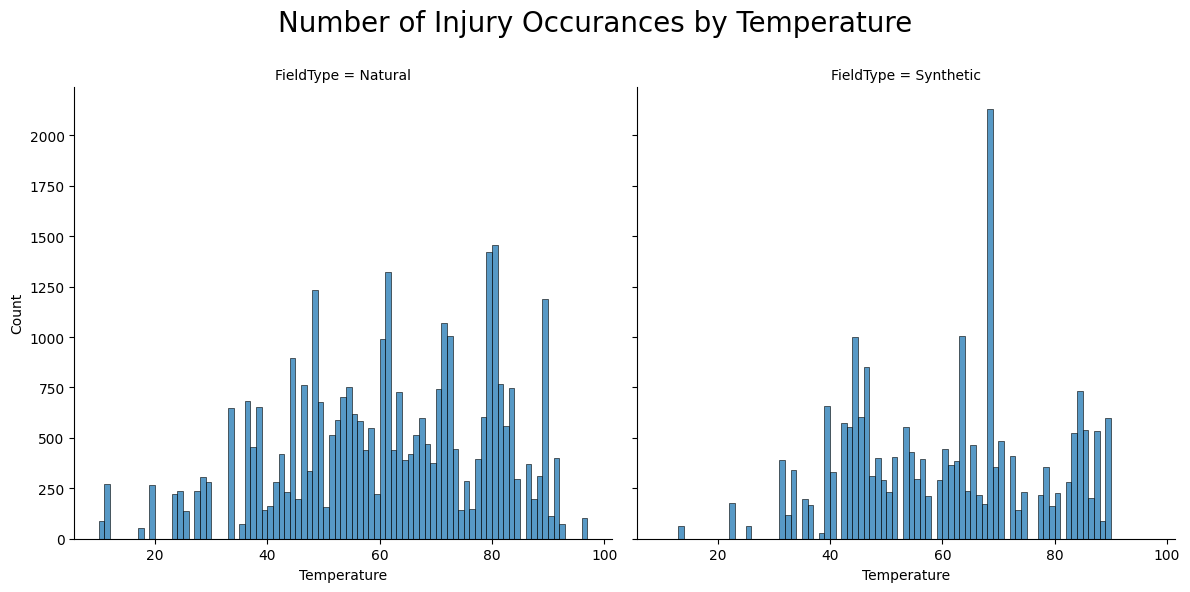

In [ ]:
#Field Type/Surface vs. Temperature
graph = sns.FacetGrid(df, col="FieldType", height=6)
graph.map_dataframe(sns.histplot,x="Temperature",binwidth=1)

#Setting the title for the FacetGrid
graph.fig.subplots_adjust(top=0.85)
graph.fig.suptitle('Number of Injury Occurances by Temperature', fontsize=20)